## Overview
This notebook downloads earthquake data (USGS catalog) and plots earthquake magnitudes vs. epicentral distance.
It requires several python packages, at least:

1. numpy
1. matplotlib
1. cartopy

In [142]:
import numpy as np
# Download earthquake catalog data
lusi_coord = (-7.526469, 112.711131) # lat,lon
lusi_lon = lusi_coord[1]
lusi_lat = lusi_coord[0]

data_site    = "https://earthquake.usgs.gov/fdsnws/event/1/query.csv"
text_query = "?starttime=1976-01-01%2000:00:00&endtime=2006-05-28%2023:59:59&latitude=-7.526469&longitude=112.711131&maxradiuskm=1500&minmagnitude=4.0&eventtype=earthquake&orderby=time"
url = data_site + text_query
print("The URL request will be:")
print(url)

The URL request will be:
https://earthquake.usgs.gov/fdsnws/event/1/query.csv?starttime=1976-01-01%2000:00:00&endtime=2006-05-28%2023:59:59&latitude=-7.526469&longitude=112.711131&maxradiuskm=1500&minmagnitude=4.0&eventtype=earthquake&orderby=time


In [143]:
import os
import urllib.request
import shutil

outputFilename = "EQ_Catalog.txt"
os.remove(outputFilename)
with urllib.request.urlopen(url) as response, open(outputFilename, 'wb') as outputFile:
        shutil.copyfileobj(response, outputFile)
outputFile.close()

# Check that the file was downloaded
if os.path.isfile(outputFilename):
    print("File '{}' downloaded OK".format(outputFilename))
else:
    print("Error downloading '{}' ".format(outputFilename))

File 'EQ_Catalog.txt' downloaded OK


In [144]:
# Parse earthquake catalog file
eqfile = open(outputFilename)
header=None
eq_lat = []
eq_lon = []
eq_depth = []
eq_mag = []
eq_time_str = []
eq_time = []
for line in eqfile:
    if header is None:
        header=line
        field_names = header.split(',')
        time_field = field_names.index('time')
        lat_field = field_names.index('latitude')        
        lon_field = field_names.index('longitude')
        mag_field = field_names.index('mag')
        depth_field = field_names.index('depth')
    else:
        fields = line.split(',')
        eq_time_str.append(fields[time_field])
        eq_time.append( np.datetime64(fields[time_field]) )
        eq_lat.append(float(fields[lat_field]))
        eq_lon.append(float(fields[lon_field]))
        eq_mag.append(float(fields[mag_field]))
        eq_depth.append(float(fields[depth_field]))
eqfile.close()
eq_lat = np.array(eq_lat)
eq_lon = np.array(eq_lon)
eq_mag = np.array(eq_mag)
eq_depth = np.array(eq_depth)

/Users/max/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


In [146]:
# Identify yogyakarta earthquake within catalog
yogyakarta_index = eq_time_str.index('2006-05-26T22:53:58.920Z')
print(yogyakarta_index)

4


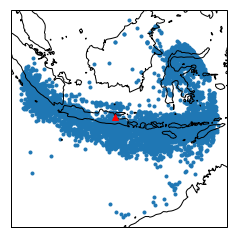

In [147]:
# Make a map of the earthquake positions
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
plt.scatter(eq_lon,eq_lat,marker='.',transform=ccrs.PlateCarree())
plt.plot(lusi_lon,lusi_lat,'r^',transform=ccrs.PlateCarree())

ax.coastlines(resolution='50m', color='black', linewidth=1)
plt.show()

In [148]:
import cartopy.geodesic as gd
globe = gd.Geodesic()
eq_dist_m = []
for lon, lat in zip(eq_lon, eq_lat):
    this_dist = globe.inverse([lusi_lon,lusi_lat],[lon,lat])[0][0]
    eq_dist_m.append(this_dist)
eq_dist_m = np.array(eq_dist_m)
eq_dist_km = eq_dist_m/1000.

In [149]:
# Load the catalog of triggered mud volcano eruptions from csv file (exported from excel spreadsheet)
mv_filename = 'MV_Summary_Table.csv'
mv_file = open(mv_filename,'r')
import csv
header = None
mv_mag = []
mv_dist = []
for line in csv.reader(mv_file, quotechar='"', delimiter=',',quoting=csv.QUOTE_ALL, skipinitialspace=True):
    if header is None:
        header = line
        mag_field = header.index('Magnitude')
        dist_field = header.index('Dist (km)')
    else:
        mv_mag.append(float(line[mag_field]))
        mv_dist.append(float(line[dist_field]))

In [150]:
# Calculate the Wang (2007) energy density curve
wang_mag = np.linspace(4,10,10)
def wang_r(M,e):
    return 10.0**(0.48*M - 0.33*np.log10(e)-1.4)
def wang_e(M,r):
    return 10.0**(1./0.33*(0.48*M-np.log10(r)-1.4))

def brumm_pga(M,r):
    """Davies et el. 2008Takes magnitude, r in km"""
    c1 = 11.2
    c2 = 1.5
    c3 = -5.26
    c4 = 0.00575
    return np.exp(c1+c2*M+c3*np.log(r)+c4*r )
def brumm_pgv(M,r):
    c1 = 4.67
    c2 = 2.04
    c3 = -4.53
    c4 = 0.00478
    return np.exp(c1+c2*M+c3*np.log(r)+c4*r )
    
yog_e = wang_e(eq_mag[yogyakarta_index],eq_dist_km[yogyakarta_index])
yog_pgv = brumm_pgv(eq_mag[yogyakarta_index],eq_dist_km[yogyakarta_index])
yog_pga = brumm_pga(eq_mag[yogyakarta_index],eq_dist_km[yogyakarta_index])
yog_mag = eq_mag[yogyakarta_index]
yog_dist = eq_dist_km[yogyakarta_index]

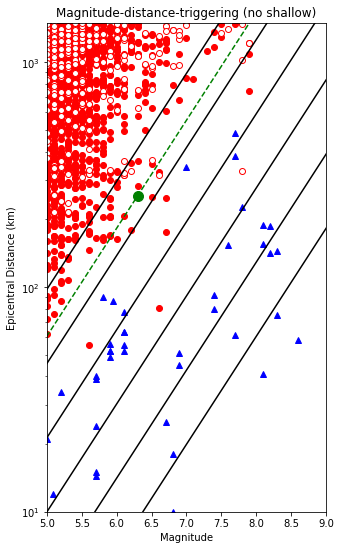

In [151]:
# Make a second figure excluding shallow events
minimum_depth = 30.
fig, ax = plt.subplots(figsize=(5,9))
plt.plot(eq_mag[eq_depth > minimum_depth],eq_dist_km[eq_depth > minimum_depth],'ro')
plt.plot(eq_mag[eq_depth <= minimum_depth],eq_dist_km[eq_depth <= minimum_depth],linestyle='none',marker='o',markerfacecolor='w',markeredgecolor='r')
plt.plot(eq_mag[yogyakarta_index],eq_dist_km[yogyakarta_index],'g.',markersize=20)
plt.plot(mv_mag,mv_dist,'b^')
plt.plot(wang_mag,wang_r(wang_mag,1e-3),'k')
plt.plot(wang_mag,wang_r(wang_mag,1e-2),'k')
plt.plot(wang_mag,wang_r(wang_mag,1e-1),'k')
plt.plot(wang_mag,wang_r(wang_mag,1e0),'k')
plt.plot(wang_mag,wang_r(wang_mag,1e1),'k')
plt.plot(wang_mag,wang_r(wang_mag,1e2),'k')
plt.plot(wang_mag,wang_r(wang_mag,yog_e),'g--')

ax.set_yscale('log')
ax.set_xlim([5, 9])
ax.set_ylim([10,1500])
plt.xlabel('Magnitude')
plt.ylabel('Epicentral Distance (km)')
plt.title('Magnitude-distance-triggering (no shallow)')
plt.savefig('magnitude-distance.png')
plt.show()

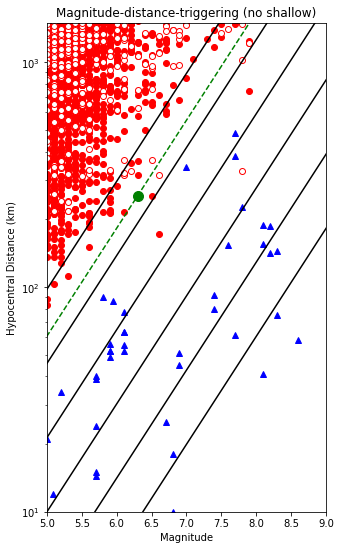

In [152]:
# calculate approximate hypocentral distance
minimum_depth = 30.
eq_hyp_dist = np.sqrt( eq_dist_km**2 + eq_depth**2 )

fig, ax = plt.subplots(figsize=(5,9))
plt.plot(eq_mag[eq_depth > minimum_depth],eq_hyp_dist[eq_depth > minimum_depth],'ro')
plt.plot(eq_mag[eq_depth <= minimum_depth],eq_hyp_dist[eq_depth <= minimum_depth],linestyle='none',marker='o',markerfacecolor='w',markeredgecolor='r')
plt.plot(eq_mag[yogyakarta_index],eq_hyp_dist[yogyakarta_index],'g.',markersize=20)
plt.plot(mv_mag,mv_dist,'b^')
plt.plot(wang_mag,wang_r(wang_mag,1e-3),'k')
plt.plot(wang_mag,wang_r(wang_mag,1e-2),'k')
plt.plot(wang_mag,wang_r(wang_mag,1e-1),'k')
plt.plot(wang_mag,wang_r(wang_mag,1e0),'k')
plt.plot(wang_mag,wang_r(wang_mag,1e1),'k')
plt.plot(wang_mag,wang_r(wang_mag,1e2),'k')
plt.plot(wang_mag,wang_r(wang_mag,yog_e),'g--')

ax.set_yscale('log')
ax.set_xlim([5, 9])
ax.set_ylim([10,1500])
plt.xlabel('Magnitude')
plt.ylabel('Hypocentral Distance (km)')
plt.title('Magnitude-distance-triggering (no shallow)')
plt.savefig('magnitude-distance.png')
plt.show()

In [153]:
# Calculate the Wang (2007) seismic energy density for every event in the catalog.
from IPython.display import Markdown, display
eq_e = wang_e(eq_mag, eq_dist_km)
eq_pga = brumm_pga(eq_mag,eq_dist_km)

table = "| Time | Mag | Depth (km) | Distance (km) | Lat | Lon | Energy Density\n"
table = table + "|---|---|---|---|---|---|---|\n"
for i in range(len(eq_e)):
    if eq_e[i] >= yog_e and eq_depth[i] > minimum_depth:
        table += "|" + str(eq_time[i])    + '|' + str(eq_mag[i]) + '|'+ str(eq_depth[i]) \
               + '|' + str(eq_dist_km[i]) + '|' + str(eq_lat[i]) + '|' + str(eq_lon[i])  \
               + '|' + str(eq_e[i]) + '|\n'
display(Markdown(table))


| Time | Mag | Depth (km) | Distance (km) | Lat | Lon | Energy Density
|---|---|---|---|---|---|---|
|2005-07-09T22:42:04.080|4.4|261.1|1.97115934568|-7.517|112.696|18.3856757084|
|2005-01-20T16:09:44.760|4.7|184.8|26.7115982959|-7.68|112.898|0.0186468913193|
|2000-06-04T16:28:26.170|7.9|33.0|1216.07079338|-4.721|102.087|0.00794556294574|
|2000-05-07T19:21:52.040|4.9|48.6|51.7795123978|-7.985|112.806|0.00490264486392|
|1998-09-28T13:34:30.490|6.6|151.6|80.8156913475|-8.194|112.413|0.377820727808|
|1996-06-17T11:22:18.540|7.9|587.3|1091.49431319|-7.137|122.589|0.0110245065448|
|1996-01-09T15:31:33.570|4.5|160.5|23.2852176597|-7.655|112.544|0.0144664750244|
|1994-09-28T16:39:51.670|6.6|637.5|324.174730787|-5.786|110.352|0.00561247040665|
|1992-12-27T21:49:04.470|6.0|600.9|163.53829537|-6.087|113.05|0.00598288571822|
|1992-09-02T05:50:01.900|6.7|624.6|175.55526211|-6.046|112.138|0.0503241220924|
|1992-05-14T18:19:11.160|4.7|33.0|37.5426663641|-7.376|113.016|0.00664739015975|
|1985-08-08T16:18:02.630|6.2|592.2|179.575335663|-6.102|113.491|0.00880454686398|
|1984-07-09T23:19:03.570|6.7|533.5|247.742158778|-5.788|111.298|0.0177208723856|
|1978-10-14T18:41:13.700|5.6|184.0|55.0848483156|-7.464|112.216|0.0423813980824|
|1977-08-19T06:08:55.200|7.9|33.0|744.466371148|-11.085|118.464|0.0351498912579|
|1976-07-14T07:13:24.000|6.5|40.0|250.399049728|-8.17|114.888|0.00878086589133|


In [154]:
# Calculate the Wang (2007) seismic energy density for every event in the catalog.
eq_e = wang_e(eq_mag, eq_dist_km)

print('ALL events with seismic energy density equal or greater than Yogyakarta')
print('yogyakarta energy density ',yog_e)
table = "| Time | Mag | Depth (km) | Distance (km) | Lat | Lon | Energy Density\n"
table = table + "|---|---|---|---|---|---|---|\n"
for i in range(len(eq_e)):
    if eq_e[i] >= yog_e:
        table += "|" + str(eq_time[i])    + '|' + str(eq_mag[i]) + '|'+ str(eq_depth[i]) \
               + '|' + str(eq_dist_km[i]) + '|' + str(eq_lat[i]) + '|' + str(eq_lon[i])  \
               + '|' + str(eq_e[i]) + '|\n'
display(Markdown(table))        

ALL events with seismic energy density equal or greater than Yogyakarta
yogyakarta energy density  0.00428076346774


| Time | Mag | Depth (km) | Distance (km) | Lat | Lon | Energy Density
|---|---|---|---|---|---|---|
|2006-05-26T22:53:58.920|6.3|12.5|254.447385955|-7.961|110.446|0.00428076346774|
|2005-07-09T22:42:04.080|4.4|261.1|1.97115934568|-7.517|112.696|18.3856757084|
|2005-01-20T16:09:44.760|4.7|184.8|26.7115982959|-7.68|112.898|0.0186468913193|
|2000-06-04T16:28:26.170|7.9|33.0|1216.07079338|-4.721|102.087|0.00794556294574|
|2000-05-07T19:21:52.040|4.9|48.6|51.7795123978|-7.985|112.806|0.00490264486392|
|1998-09-28T13:34:30.490|6.6|151.6|80.8156913475|-8.194|112.413|0.377820727808|
|1996-06-17T11:22:18.540|7.9|587.3|1091.49431319|-7.137|122.589|0.0110245065448|
|1996-01-09T15:31:33.570|4.5|160.5|23.2852176597|-7.655|112.544|0.0144664750244|
|1996-01-01T08:05:10.830|7.9|24.0|1214.88487454|0.729|119.931|0.00796908963787|
|1994-09-28T16:39:51.670|6.6|637.5|324.174730787|-5.786|110.352|0.00561247040665|
|1994-06-03T21:06:59.880|6.6|25.9|314.243543769|-10.362|112.892|0.00616739732498|
|1994-06-02T18:17:34.020|7.8|18.4|326.617784152|-10.477|112.835|0.305300695417|
|1992-12-27T21:49:04.470|6.0|600.9|163.53829537|-6.087|113.05|0.00598288571822|
|1992-12-12T05:29:26.350|7.8|27.7|1018.00568775|-8.48|121.896|0.00974172227104|
|1992-09-02T05:50:01.900|6.7|624.6|175.55526211|-6.046|112.138|0.0503241220924|
|1992-05-14T18:19:11.160|4.7|33.0|37.5426663641|-7.376|113.016|0.00664739015975|
|1985-08-08T16:18:02.630|6.2|592.2|179.575335663|-6.102|113.491|0.00880454686398|
|1984-07-09T23:19:03.570|6.7|533.5|247.742158778|-5.788|111.298|0.0177208723856|
|1978-10-14T18:41:13.700|5.6|184.0|55.0848483156|-7.464|112.216|0.0423813980824|
|1977-08-19T06:08:55.200|7.9|33.0|744.466371148|-11.085|118.464|0.0351498912579|
|1976-07-14T07:13:24.000|6.5|40.0|250.399049728|-8.17|114.888|0.00878086589133|


In [155]:
# Calculate the Wang (2007) seismic energy density for every event in the catalog.
# Same as previous, except approximate HYPO-central distance
eq_e = wang_e(eq_mag, eq_hyp_dist )
eq_pga = brumm_pga(eq_mag,eq_hyp_dist)
eq_pgv = brumm_pgv(eq_mag,eq_hyp_dist)

yog_e = eq_e[yogyakarta_index]
print('Events of all depths with seismic energy density equal or greater than Yogyakarta')
print('yogyakarta energy density ',yog_e)
table = "| Time | Mag | Depth (km) | Epicenter Dist. (km) | Hypocenter Dist. (km) | Lat | Lon | Energy Density | PGA | PGV |\n"
table = table + "|---|---|---|---|---|---|---|---|---|---|---|---|\n"
for i in range(len(eq_e)):
    if eq_e[i] >= yog_e:
        table += "|" + str(eq_time[i])    + '|' + str(eq_mag[i]) + '|'+ str(eq_depth[i]) \
               + '|' + '{:.2f}'.format(eq_dist_km[i]) + '|' + '{:.2f}'.format(eq_hyp_dist[i]) + '|' + str(eq_lat[i]) + '|' + str(eq_lon[i])  \
               + '|' + '{:1.2e}'.format(eq_e[i]) + '|' + '{:1.2e}'.format(eq_pga[i]) + '|' + '{:1.2e}'.format(eq_pgv[i]) + '|\n'
display(Markdown(table))

Events of all depths with seismic energy density equal or greater than Yogyakarta
yogyakarta energy density  0.00426515770582


| Time | Mag | Depth (km) | Epicenter Dist. (km) | Hypocenter Dist. (km) | Lat | Lon | Energy Density | PGA | PGV |
|---|---|---|---|---|---|---|---|---|---|---|---|
|2006-05-26T22:53:58.920|6.3|12.5|254.45|254.75|-7.961|110.446|4.27e-03|8.87e-04|1.73e-03|
|2000-06-04T16:28:26.170|7.9|33.0|1216.07|1216.52|-4.721|102.087|7.94e-03|6.62e-04|3.78e-03|
|1998-09-28T13:34:30.490|6.6|151.6|80.82|171.80|-8.194|112.413|3.84e-02|6.86e-03|1.28e-02|
|1996-06-17T11:22:18.540|7.9|587.3|1091.49|1239.47|-7.137|122.589|7.50e-03|6.84e-04|3.87e-03|
|1996-01-01T08:05:10.830|7.9|24.0|1214.88|1215.12|0.729|119.931|7.96e-03|6.60e-04|3.77e-03|
|1994-06-03T21:06:59.880|6.6|25.9|314.24|315.31|-10.362|112.892|6.10e-03|6.42e-04|1.62e-03|
|1994-06-02T18:17:34.020|7.8|18.4|326.62|327.14|-10.477|112.835|3.04e-01|3.43e-03|1.68e-02|
|1992-12-12T05:29:26.350|7.8|27.7|1018.01|1018.38|-8.48|121.896|9.73e-03|4.64e-04|2.67e-03|
|1977-08-19T06:08:55.200|7.9|33.0|744.47|745.20|-11.085|118.464|3.50e-02|5.80e-04|3.65e-03|
|1976-07-14T07:13:24.000|6.5|40.0|250.40|253.57|-8.17|114.888|8.45e-03|1.22e-03|2.65e-03|


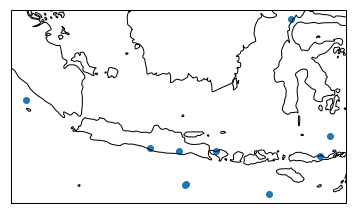

In [156]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
mask = eq_e >= yog_e
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
plt.scatter(eq_lon[mask],eq_lat[mask],marker='o',transform=ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='black', linewidth=1)
plt.show()

In [191]:
import matplotlib.dates as mdates
f, (ax1,ax2,ax3) =plt.subplots(1,3,figsize=(12,4))
#ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#ax1.xaxis_date()
ax1.plot(eq_time,eq_e)
ax1.xaxis_date()
ax1.set_ylabel('Energy Density (J/m$^3$)')

ax2.plot(eq_time,eq_pga)
ax2.set_ylabel('PGA')
ax3.plot(eq_time,eq_pgv)
ax3.set_ylabel('PGV')
plt.show()

OverflowError: signed integer is greater than maximum

In [180]:

print(eq_time[0].date)

2006-05-28T22:28:33.130Z


AttributeError: 'numpy.datetime64' object has no attribute 'date'

In [193]:
a=eq_time[0]
import as dt
dt.date2num(a)

ImportError: No module named 'numpy.dt'